In [20]:
import pandas as pd
import matplotlib.pyplot as plt

### Visualizing Mutually Non-Exclusive Labels

In [21]:
labels_df = pd.read_csv("selected_labels.csv", index_col=0) # .set_index(keys=labels_df['img_id'], drop=True)

In [22]:
labels_df

Gate  Start/Restar the game  The joy of the players  \
Image Number                                                        
1                0                      0                       0   
2                0                      0                       0   
94               0                      0                       0   
95               0                      0                       0   
96               0                      0                       0   
...            ...                    ...                     ...   
88281            0                      0                       0   
35162            0                      0                       0   
47062            0                      0                       0   
83692            0                      0                       0   
87448            0                      0                       0   

              yellow card  Red Card  Ball  Stadium View  referee Image  \
Image Number                                                             
1                       0         0     0             1              0   
2                       0         0     0             1              1   
94                      1         0     1             0              1   
95                      1         0     1             0              1   
96                      1         0     1             0              1   
...                   ...       ...   ...           ...            ...   
88281                   0         0     1             0              1   
35162                   0         0     1             0              1   
47062                   0         0     0             0              0   
83692                   0         0     0             0              0   
87448                   0         0     0             0              0   

              Penalty Image  Free Kick  Generic Moment  
Image Number                                            
1                         0          0               0  
2                         0          0               0  
94                        0          0               0  
95                        0          0               0  
96                        0          0               0  
...                     ...        ...             ...  
88281                     0          0               1  
35162                     0          0               1  
47062                     0          0               1  
83692                     0          0               1  
87448                     0          0               1  

[10000 rows x 11 columns]

In [23]:
#labels_df.index.to_list()

In [24]:
labels_df.columns

Index(['Gate', 'Start/Restar the game', 'The joy of the players',
       'yellow card', 'Red Card', 'Ball', 'Stadium View', 'referee Image',
       'Penalty Image', 'Free Kick', 'Generic Moment'],
      dtype='object')

We discard the classes that were considered as 'Events of the Match' from the dataset of clues we want to construct:

indeed, the presence of the gate or the ball can often be meaningful to understand whether the portrayed scene is about players cheering, stadium view or a part of the game (such as Penalty, Free Kick). Instead, the presence of the referee can be more significant to predict the 'Red Card', 'Yellow Card' Events.

In [25]:
clues_df = pd.DataFrame({'img_id': labels_df.index.to_list(),
                         'Gate': labels_df['Gate'].to_list(),
                         'Ball':labels_df['Ball'].to_list(),
                         'Referee':pd.to_numeric(labels_df['referee Image'].astype(str).str.strip(), errors='coerce').fillna(0).astype(int).to_list()}
                         )
clues_df.set_index(clues_df.columns[0], inplace=True)

In [26]:
clues_df.head()

Gate  Ball  Referee
img_id                     
1          0     0        0
2          0     0        1
94         0     1        1
95         0     1        1
96         0     1        1

These are binary indicators telling if the object/clue is present in the image. For now we don’t have the location (bounding boxes) of the objects in the image, but presence is already informative.

check if there are some images in the dataset which do not contain any of the clues:

In [27]:
no_clue_images = clues_df[(clues_df == 0).all(axis=1)]
print(no_clue_images.head())
print(f"There are {len(no_clue_images)} that do not contain any clue")

        Gate  Ball  Referee
img_id                     
1          0     0        0
102        0     0        0
642        0     0        0
947        0     0        0
1827       0     0        0
There are 3566 that do not contain any clue


We still have 6437 images containing at least one clue

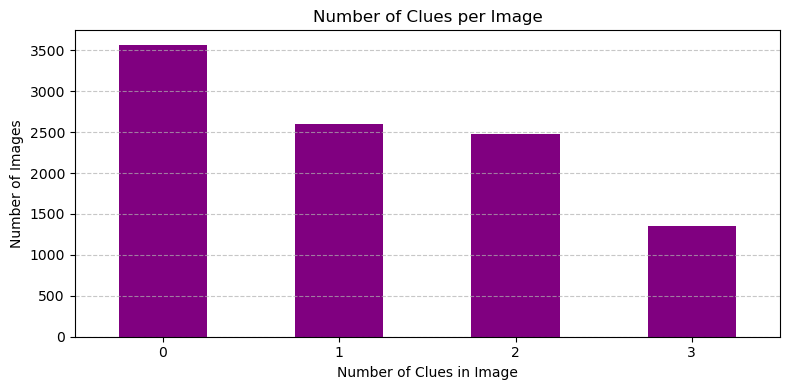

In [28]:
clue_counts = clues_df.sum(axis=1)

# Count how many images have 0, 1, 2, ..., n clues
clue_count_distr = clue_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 4))
clue_count_distr.plot(kind='bar', color='purple')
plt.title("Number of Clues per Image")
plt.xlabel("Number of Clues in Image")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We observe that the majority of the images, according to the labels set by the curators of the dataset, do not contain any of the clues we need for our analysis.

However, we can still consider images without any clue (i.e., all zeros) as valid. They might represent neutral moments (e.g., mid-field play) or scenes without distinctive objects.

If the architecture concatenates a clue vector (e.g., [Gate, Ball, Referee, ...]) to image features, an all-zero vector is just one possible input — no problem. We keep in mind that the model might learn that a vector of all 0s corresponds to certain classes (e.g., “generic moment”), which may or may not be desirable.

- Mask Augmentation:
    In the case we feed binary masks (e.g., ball mask, gate mask) as additional input channels, an image with no clues will have empty mask channels.
    This is fine, in order to let the model learn that “absence of signal” is also a signal.


- Training Bias:
    Of course, if very few images have clues, the model may ignore them. In the same way, if most of them have clues, the model may depend on them too heavily and fail to generalize.

Now we analyze how the clues are distributed across the dataset:

In [29]:
for x in clues_df.columns:
    print(f'Clue {x} appears {clues_df[x].sum()} times')

Clue Gate appears 4150 times
Clue Ball appears 4220 times
Clue Referee appears 3254 times


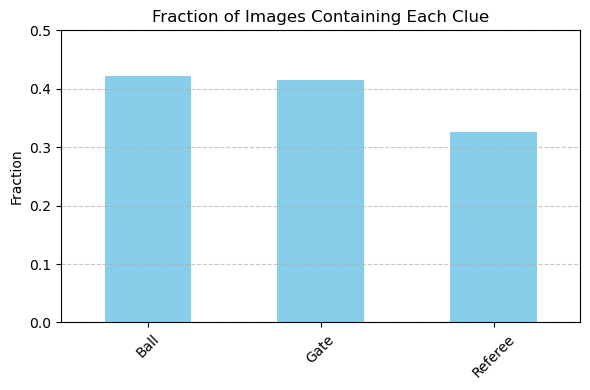

In [30]:
clue_fractions = (clues_df > 0).sum() / clues_df.shape[0]

# Plot
plt.figure(figsize=(6, 4))
clue_fractions.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Fraction of Images Containing Each Clue")
plt.ylabel("Fraction")
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As expected, a higher fraction of image is likely to contain the objects 'Ball' and 'Gate', since they are more likely to be present in diverse moments of the match, while the referee is more likely shown on video when his presence is relevant for some kinds of interventions on the field.

It is also interesting to notice whether Ball and Gate are expressed in approximately 40% of images because they are coexisting, or if they belong to different categories.

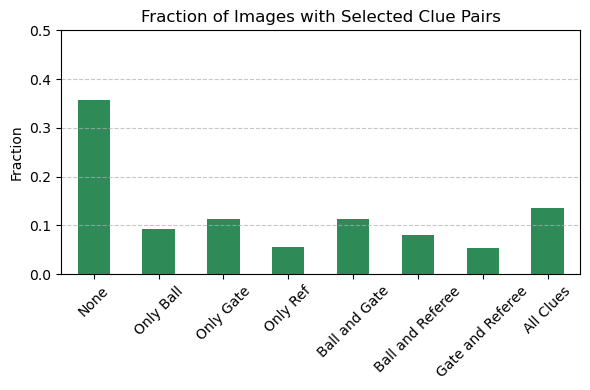

In [31]:
total_images = clues_df.shape[0]

# Compute co-occurrence fractions
no_clues = ((clues_df['Ball'] == 0)& (clues_df['Gate'] == 0) & (clues_df['Referee'] == 0)).sum() / total_images
only_ball = ((clues_df['Ball'] == 1)& (clues_df['Gate'] == 0) & (clues_df['Referee'] == 0)).sum() / total_images
only_gate = ((clues_df['Gate'] == 1)&(clues_df['Ball'] == 0) & (clues_df['Referee'] == 0)).sum() / total_images
only_ref = ((clues_df['Ball'] == 0)&(clues_df['Gate'] == 0)& (clues_df['Referee'] == 1)).sum() / total_images
ball_gate = ((clues_df['Ball'] == 1) & (clues_df['Gate'] == 1) & (clues_df['Referee'] == 0)).sum() / total_images
ball_ref = ((clues_df['Ball'] == 1) & (clues_df['Referee'] == 1) & (clues_df['Gate'] == 0)).sum() / total_images
gate_ref = ((clues_df['Ball'] == 0)&(clues_df['Gate'] == 1) & (clues_df['Referee'] == 1)).sum() / total_images
bgr = ((clues_df['Ball'] == 1) & (clues_df['Gate'] == 1) & (clues_df['Referee'] == 1)).sum() / total_images

# Create a Series for plotting
co_occurrence_fractions = {
    'None' : no_clues,
    'Only Ball' : only_ball,
    'Only Gate' : only_gate,
    'Only Ref': only_ref,
    'Ball and Gate': ball_gate,
    'Ball and Referee': ball_ref,
    'Gate and Referee': gate_ref,
    'All Clues': bgr
}

# Plot
plt.figure(figsize=(6, 4))
pd.Series(co_occurrence_fractions).plot(kind='bar', color='seagreen')
plt.title("Fraction of Images with Selected Clue Pairs")
plt.ylabel("Fraction")
plt.ylim(0, 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Still, the majority of the images does not contain any of the objects 'Ball', 'Gate', 'Referee'.

- Weight on rare clues:
    - rare clues like red card can be highly discriminative (e.g., if a red card is present, the scene probably relates to a sending-off event).
    - Due to scarcity, they should not dominate the model loss
    - they shouldn’t be dropped, either

- Keep them in the clue vector — let the classifier learn their informativeness
- Also, even though red_card and yellow_card are hardly co-occurring, it is better not to merge them in a new label 'Card_Presence' to allow the model to learn their difference (?????)

(In MLP classifier, use dropout + batch norm to prevent overfitting to rare clues)?

You could apply manual weighting only if you observe the model ignoring rare clues during ablation

 already have weak labels for object presence at the image level, which makes your task a weakly supervised feature enrichment problem rather than pure object detection.

## Testing the Labels' Reliability

I start by manually checking whether there is some mistake in the labels (eg false presence, or false absence).

In [34]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import os

In [44]:
def display_samples(df, clue_name, label_value=1, rows=3, cols=5, image_folder="Dataset/"):
    total = rows * cols
    sample_ids = df[df[clue_name] == label_value].sample(total).index
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for i, img_id in enumerate(sample_ids):
        img_path = os.path.join(image_folder, f"{img_id}.jpg")
        try:
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f"{clue_name}: {label_value} - img {img_id}")
        except Exception as e:
            axs[i].set_visible(False)
            print(f"Error loading {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

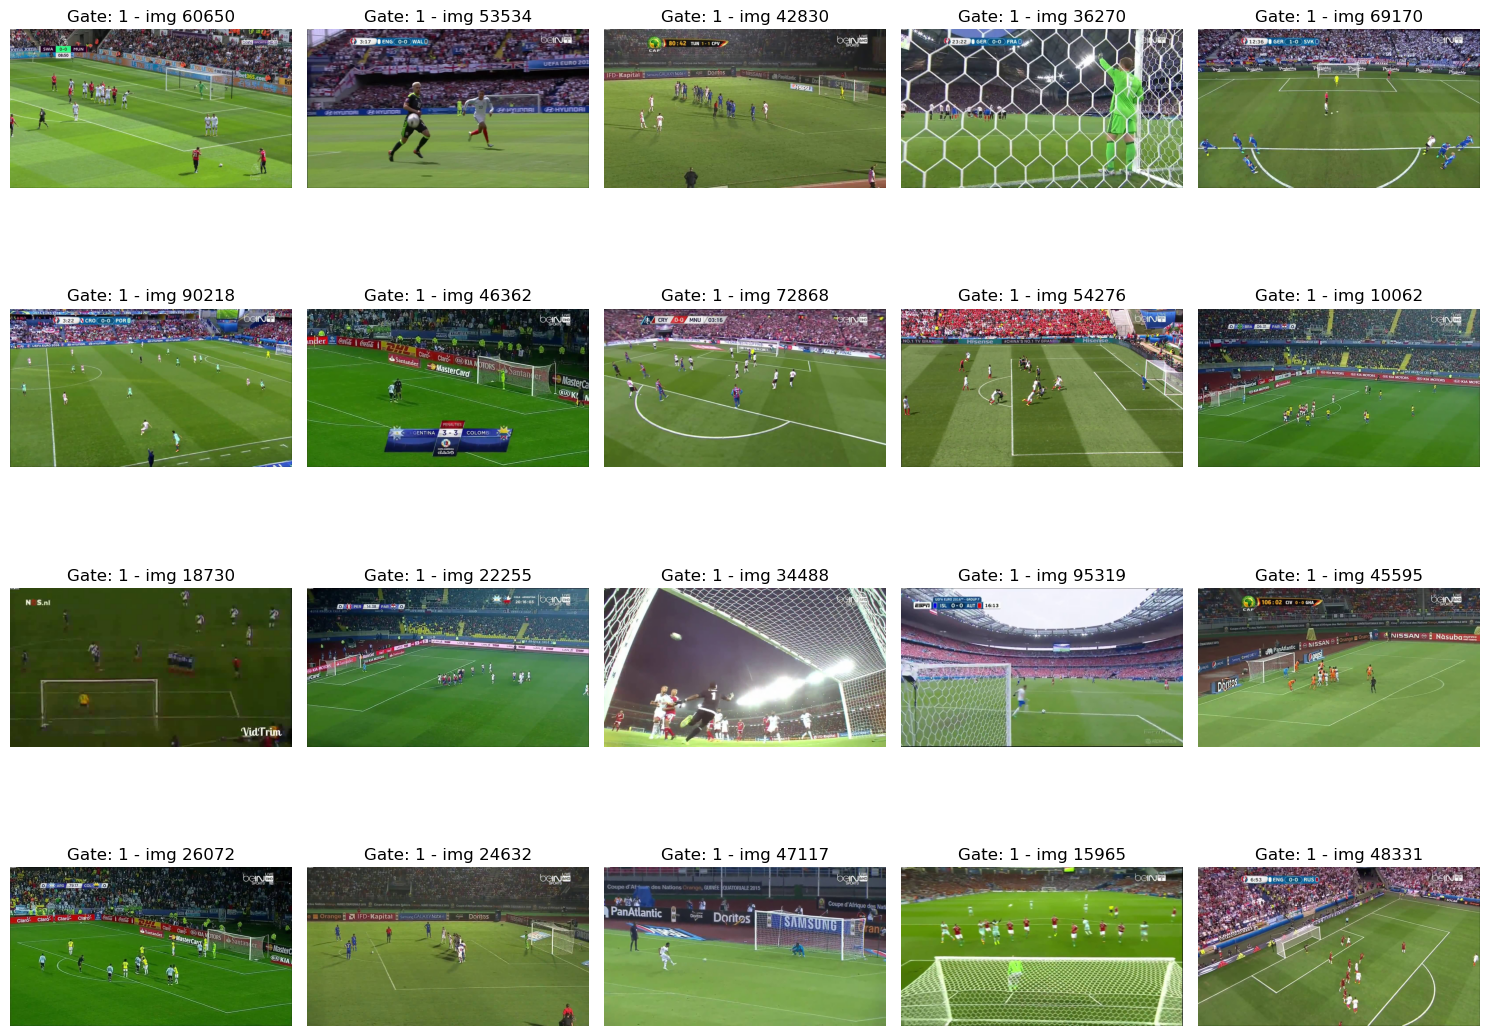

In [45]:
display_samples(clues_df, "Gate", label_value=1, rows=4, cols=5)

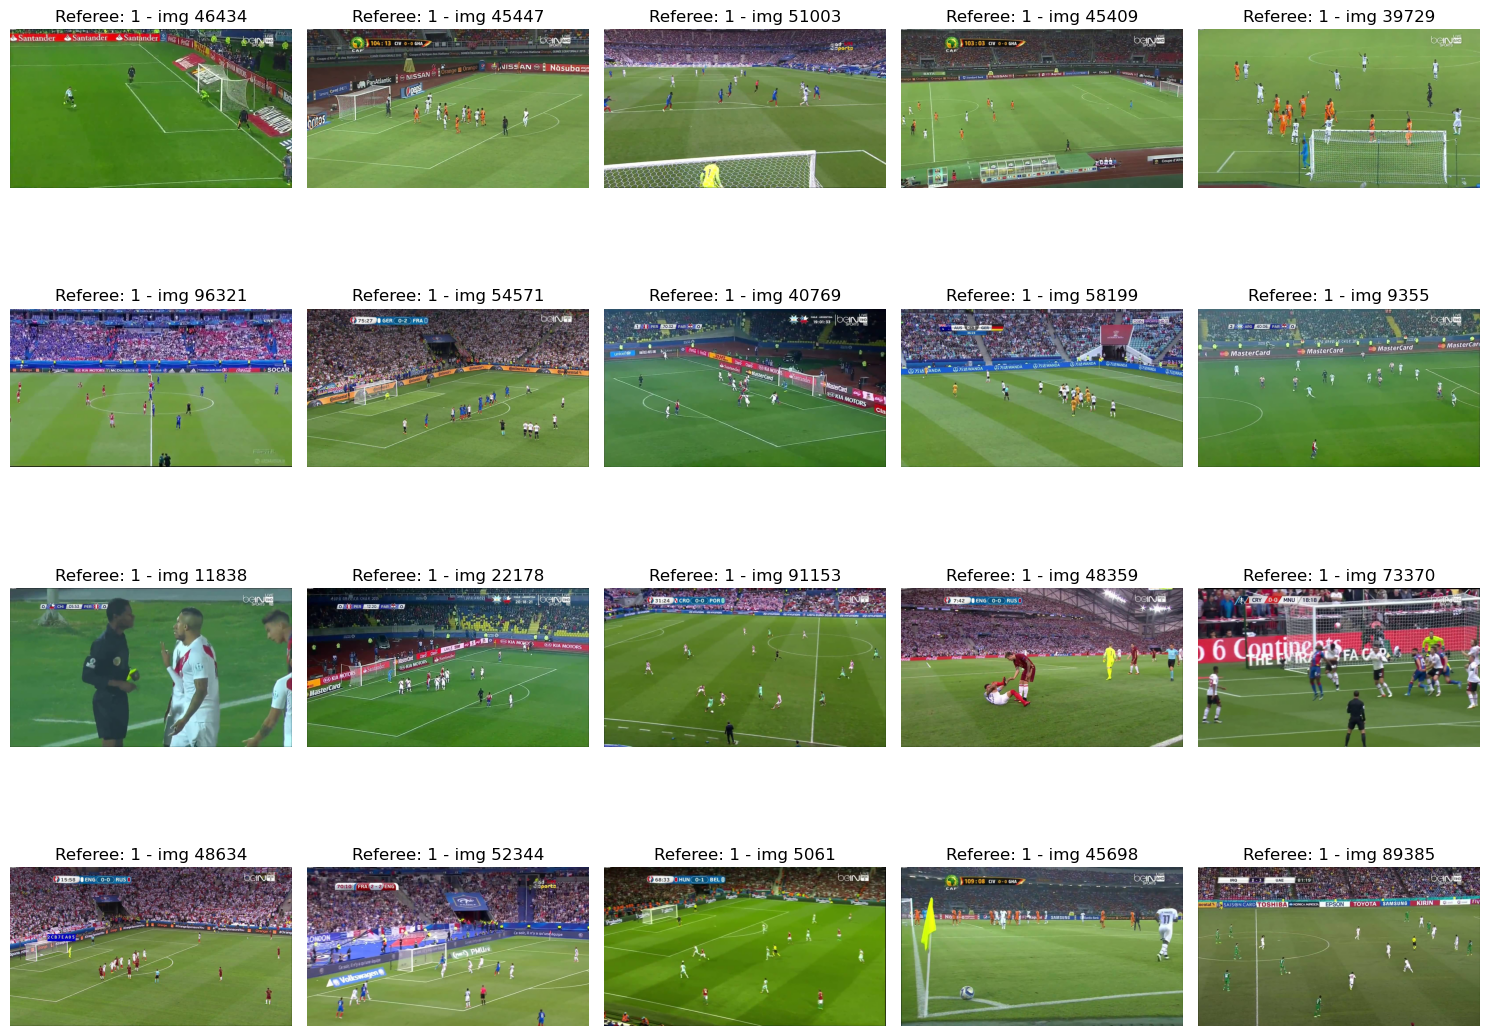

In [47]:
display_samples(clues_df, "Referee", label_value=1, rows=4, cols=5)

In [49]:
print(len(no_clue_images))
print(no_clue_images.index.to_list())
no_clue_images.head()

3566
[1, 102, 642, 947, 1827, 1927, 1928, 1929, 1930, 1934, 1979, 1980, 2943, 2944, 3472, 3793, 3869, 3904, 4015, 4126, 4237, 4275, 4276, 4334, 4340, 4341, 4795, 4796, 5018, 5348, 5360, 5388, 5389, 5390, 5391, 5392, 5393, 5395, 5410, 5411, 5413, 5414, 5415, 5417, 5746, 5780, 5784, 5787, 5788, 5807, 5840, 5841, 5852, 5854, 5934, 5935, 5936, 5937, 6049, 6098, 6099, 6100, 6133, 6134, 6184, 6216, 6221, 6222, 6223, 6224, 6225, 6227, 6228, 6229, 6230, 6613, 6877, 6908, 7135, 7361, 7578, 7682, 7785, 7786, 7787, 7793, 7800, 7801, 8406, 8427, 8462, 8494, 8495, 8498, 8499, 8500, 8505, 8506, 8827, 8838, 8849, 8860, 8878, 8879, 8880, 8881, 8899, 8900, 8901, 8902, 8931, 8932, 9007, 9029, 9093, 9107, 9108, 9109, 9110, 9292, 9440, 9456, 9457, 9716, 9720, 9721, 9722, 9723, 9724, 9725, 9755, 9838, 9846, 9890, 10328, 10339, 10341, 10342, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10655, 11064, 11091, 11413, 11414, 11416, 11417, 11447, 11519, 11520, 11521, 11522, 11534, 11535, 11542, 11543, 11560, 

Gate  Ball  Referee
img_id                     
1          0     0        0
102        0     0        0
642        0     0        0
947        0     0        0
1827       0     0        0

### Feature Vectors

A. Can convert each row into a feature vector of clues, which will later be fed into the classification model as additional **feature input**.

The images go into the CNN --> the clue vector goes into the MLP. So will concatenate CNN embedding + clue vector and feed it into the final classifier (MLP + softmax for the mutually exclusive match events).

Feed one at a time, then all of them together???

In [67]:
ball_df = pd.DataFrame({'img_id': clues_df.index.to_list(),
                         'Ball': clues_df['Ball'].to_list()}
                         )
ball_df.set_index(ball_df.columns[0], inplace=True)
ball_df.head(10)
print(ball_df[ball_df['Ball']==0].index.to_list())

[1, 2, 100, 102, 210, 211, 212, 213, 366, 606, 607, 636, 642, 942, 943, 944, 947, 1118, 1238, 1823, 1824, 1827, 1906, 1923, 1927, 1928, 1929, 1930, 1934, 1979, 1980, 1982, 2153, 2943, 2944, 2952, 3345, 3347, 3363, 3472, 3793, 3852, 3869, 3904, 4015, 4126, 4237, 4275, 4276, 4334, 4340, 4341, 4785, 4795, 4796, 4904, 5008, 5015, 5018, 5020, 5021, 5126, 5186, 5188, 5237, 5348, 5349, 5359, 5360, 5374, 5388, 5389, 5390, 5391, 5392, 5393, 5395, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5417, 5515, 5517, 5518, 5521, 5658, 5659, 5737, 5739, 5746, 5780, 5784, 5787, 5788, 5807, 5821, 5840, 5841, 5852, 5854, 5934, 5935, 5936, 5937, 5939, 5991, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6049, 6056, 6057, 6058, 6059, 6061, 6097, 6098, 6099, 6100, 6111, 6112, 6122, 6123, 6133, 6134, 6153, 6154, 6155, 6156, 6162, 6163, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6213, 6214, 6216, 6221, 6222, 6223, 6224, 6225, 6227, 6228, 6229, 6230, 6363, 6364, 6613, 6868, 6877, 6904, 6908, 6948, 6995, 7133, 

In [70]:
## gate_df
gate_df = pd.DataFrame({'img_id': clues_df.index.to_list(),
                         'Gate': clues_df['Gate'].to_list()}
                         )
gate_df.set_index(gate_df.columns[0], inplace=True)


referee_df = pd.DataFrame({'img_id': clues_df.index.to_list(),
                         'Referee': clues_df['Referee'].to_list()}
                         )
referee_df.set_index(referee_df.columns[0], inplace=True)

In [50]:
clues_df.to_csv("clues.csv", index_label='img_id')

In [53]:
#pd.read_csv('clues.csv', index_col=0)